## Initial Package Import and Simple Module definition

Modified from ZFTurbo

In [88]:
%matplotlib inline


import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from operator import itemgetter
import random
import os
import time
import glob
import re
from multiprocessing import Process
import copy

#Importing old and new Kfold
from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold as NewKF

#Importing GroupKfold, only available since version 0.18
from sklearn.model_selection import GroupKFold


#Importing function for scaling data before PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

#Importing PCA packages
from sklearn.decomposition import PCA, KernelPCA

#Importing FFT package
from scipy.fftpack import fft

#Importing crossvalidation metrics and Gridsearch
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

#Importing wrapper to use XGB with Gridsearch

from xgboost.sklearn import XGBClassifier

#Importing plotting packages (optional)

import matplotlib.pylab as plt

from pandas.tools.plotting import scatter_matrix

from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupShuffleSplit

#Oversampling

from imblearn.over_sampling import SMOTE

from collections import Counter

from imblearn.combine import SMOTETomek



#Defining general modules used in the classification

random.seed(2016)
np.random.seed(2016)


def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]


def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance


def intersect(a, b):
    return list(set(a) & set(b))


def print_features_importance(imp):
    for i in range(len(imp)):
        print("# " + str(imp[i][1]))
        print('output.remove(\'' + imp[i][0] + '\')')


def mat_to_pandas(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    sequence = -1
    if 'sequence' in names:
        sequence = mat['dataStruct']['sequence']
    return pd.DataFrame(ndata['data'], columns=ndata['channelIndices'][0]), sequence

def create_submission(score, test, prediction):
    # Make Submission
    now = datetime.datetime.now()
    sub_file = 'submission_' + str(score) + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print('Writing submission: ', sub_file)
    f = open(sub_file, 'w')
    f.write('File,Class\n')
    total = 0
    for id in test['Id']:
        patient = id // 100000
        fid = id % 100000
        str1 = str(patient) + '_' + str(fid) + '.mat' + ',' + str(prediction[total])
        str1 += '\n'
        total += 1
        f.write(str1)
    f.close()


def get_features(train, test):
    trainval = list(train.columns.values)
    testval = list(test.columns.values)
    output = intersect(trainval, testval)
    output.remove('Id')
    # output.remove('file_size')
    return sorted(output)

    


## Module for Creating Features and Saving to CSV Files

#### One file per patient per test/training

In [129]:
#Modules to read train and test data.


def create_simple_csv_train(patient_id, feature_model, short_dataset=False):
    
    feature_file='_'+str(feature_model)
    
    if short_dataset:
        
        source_dir="./data/train_"
    else:
        source_dir="./train_"
        
    

    out = open("simple_train_" + str(patient_id) + feature_file + ".csv", "w")
    out.write("Id,sequence_id,patient_id")
    for i in range(16):
        out.write(",avg_" + str(i))
    out.write(",file_size,result\n")

    # TRAIN (0)
    out_str = ''
    files = sorted(glob.glob(source_dir + str(patient_id) + "/*.mat"), key=natural_key)
    print ('train files'+ str(patient_id), len(files))    
    pos1=0
    neg1=0
    sequence_id = int(patient_id)*1000
    total = 0
    seq1=0
    for fl in files:
        total += 1
        # print('Go for ' + fl)
        id_str = os.path.basename(fl)[:-4]
        arr = id_str.split("_")
        patient = int(arr[0])
        id = int(arr[1])
        result = int(arr[2])
        new_id = patient*100000 + id
        try:
            tables, sequence_from_mat = mat_to_pandas(fl)
        except:
            print('Some error here {}...'.format(fl))
            continue
        out_str += str(new_id) + "," + str(sequence_id) + "," + str(patient)

        sizesignal=int(tables.shape[0])       
        
        for f in sorted(list(tables.columns.values)):
            
            out_str=feature_eng(tables[f],out_str,feature_model)
            
            
        out_str += "," + str(os.path.getsize(fl)) + "," + str(result) + "\n"
        #print(sequence_from_mat)
        #print(type(sequence_from_mat))
        seq1=int(sequence_from_mat[0][0][0][0])
        print(total, seq1)
        if (total % 6 == 0) and (seq1==6):
            if result != 0:
                pos1 += 1
                print('Positive ocurrence sequence finished', pos1)
            else:
                neg1 += 1
                print('Negative ocurrence sequence finished', neg1)
                
            sequence_id += 1
            print ('sequence',sequence_id)

    out.write(out_str)
    
    out.close()
    print('Train CSV for patient {} has been completed...'.format(patient_id))


def create_simple_csv_test(patient_id, feature_model, short_dataset=False):
    
    feature_file='_'+str(feature_model)
    
    if short_dataset:
        
        source_dir="./data/train_"
    else:
        source_dir="./train_"

    # TEST
    out_str = ''
    files = sorted(glob.glob(source_dir + str(patient_id) + "/*.mat"), key=natural_key)
    print ('test files'+ str(patient_id), len(files))    
    out = open("simple_test_" + str(patient_id) + feature_file + ".csv", "w")
    out.write("Id,patient_id")
    for i in range(16):
        out.write(",avg_" + str(i))
    out.write(",file_size\n")
    for fl in files:
        # print('Go for ' + fl)
        id_str = os.path.basename(fl)[:-4]
        arr = id_str.split("_")
        patient = int(arr[0])
        id = int(arr[1])
        new_id = patient*100000 + id
        try:
            tables, sequence_from_mat = mat_to_pandas(fl)
        except:
            print('Some error here {}...'.format(fl))
            continue
        out_str += str(new_id) + "," + str(patient)

        sizesignal=int(tables.shape[0])           
        
        
        
        
        for f in sorted(list(tables.columns.values)):
            
            out_str=feature_eng(tables[f],out_str,feature_model)
                        
        out_str += "," + str(os.path.getsize(fl)) + "\n"
        # break

    out.write(out_str)
    out.close()
    print('Test CSV for patient {} has been completed...'.format(patient_id))


## Feature Engineering

In [124]:
def feature_eng(data_sensor, out_str, eng_number):

                
    yf1 = fft(data_sensor)
    fftpeak=2.0/sizesignal * np.abs(yf1[0:sizesignal/2])
 
    numberofbands=4

    sizeband=20/numberofbands


    if eng_number==2:
        
        mean = data_sensor.mean()
        
        peak1=fftpeak[0:3].mean()            
        peak2=fftpeak[3:6].mean()          
        peak3=fftpeak[6:9].mean()
        peak4=fftpeak[9:12].mean()
        peak5=fftpeak[12:15].mean()            
        peak6=fftpeak[15:18].mean()          
        peak7=fftpeak[18:21].mean()
        peak8=fftpeak[21:24].mean()
        peak9=fftpeak[24:27].mean()            
        peak10=fftpeak[27:30].mean()          
        peak11=fftpeak[30:33].mean()
        peak12=fftpeak[33:36].mean()
            
        out_str += "," + str(mean)+ "," + str(peak1) + "," + str(peak2) + "," + str(peak3) +"," + str(peak4) \
                    +"," + str(peak5) + "," + str(peak6) + "," + str(peak7) +"," + str(peak8)+ "," + str(peak9) \
                    +"," + str(peak10) + "," + str(peak11) +"," + str(peak12)
    
    elif eng_number==1:
            
        mean = data_sensor.mean()   
        
        peak1=fftpeak[0:5].mean()            
        peak2=fftpeak[5:10].mean()          
        peak3=fftpeak[10:15].mean()
        peak4=fftpeak[15:20].mean()
        
        out_str += "," + str(mean)+ "," + str(peak1) + "," + str(peak2) + "," + str(peak3) +"," + str(peak4)
    
    elif eng_number==0:
            
        mean = data_sensor.mean()
    
        out_str += "," + str(mean)
    
    return out_str

## Module for Reading Test and Train Feature Files and Concatenating

In [113]:


def read_test_train(feature_model):
    feature_file='_'+str(feature_model)
    print("Load train.csv...")
    train1 = pd.read_csv('simple_train_1'+feature_file+'.csv')
    train2 = pd.read_csv('simple_train_2'+feature_file+'.csv')
    train3 = pd.read_csv('simple_train_3'+feature_file+'.csv')
    train = pd.concat([train1, train2, train3])
    # Remove all zeroes files
    train = train[train['file_size'] > 55000].copy()
    # Shuffle rows since they are ordered
    train = train.iloc[np.random.permutation(len(train))]
    # Reset broken index
    train = train.reset_index()
    print("Load test.csv...")
    test1 = pd.read_csv('simple_test_1'+feature_file+'.csv')
    test2 = pd.read_csv('simple_test_2'+feature_file+'.csv')
    test3 = pd.read_csv('simple_test_3'+feature_file+'.csv')
    test = pd.concat([test1, test2, test3])
    print("Process tables...")
    features = get_features(train, test)
    return train, test, features
    

 

## Running Creation of Feature Files (!!!)

In [117]:

feature_model=2


if __name__ == '__main__':
    print('XGBoost: {}'.format(xgb.__version__))
    if 1:
        # Do reading and processing of MAT files in parallel
        p = dict()
        p[1] = Process(target=create_simple_csv_train, args=(1,feature_model,short_dataset=True))
        p[1].start()
        p[2] = Process(target=create_simple_csv_train, args=(2,feature_model,short_dataset=True))
        p[2].start()
        p[3] = Process(target=create_simple_csv_train, args=(3,feature_model,short_dataset=True))
        p[3].start()
        p[4] = Process(target=create_simple_csv_test, args=(1,feature_model,short_dataset=True))
        p[4].start()
        p[5] = Process(target=create_simple_csv_test, args=(2,feature_model,short_dataset=True))
        p[5].start()
        p[6] = Process(target=create_simple_csv_test, args=(3,feature_model,short_dataset=True))
        p[6].start()
        p[1].join()
        p[2].join()
        p[3].join()
        p[4].join()
        p[5].join()
        p[6].join()

  

XGBoost: 0.6
train files1 1302
train files3 2394
train files2 2346
test files1 1584
1 1
1 1
1 1
test files2 2256
2 1
2 1
test files3 2286
3 2
3 2
4 2
4 2
5 3
2 1
5 3
6 3
6 3
7 4
8 4
3 2
7 4
9 5
4 2
8 4
10 5
5 3
6 3
11 6
9 5
12 6
Positive ocurrence sequence finished 1
sequence 1001
13 1
10 5
14 1
11 6
15 2
7 4
8 4
16 2
12 6
Positive ocurrence sequence finished 1
sequence 2001
17 3
9 5
13 1
18 3
14 1
19 4
20 4
21 5
15 2
22 5
23 6
16 2
24 6
Positive ocurrence sequence finished 2
sequence 1002
17 3
25 1
10 5
18 3
26 1
27 2
19 4
28 2
29 3
20 4
11 6
21 5
30 3
12 6
Positive ocurrence sequence finished 1
sequence 3001
13 1
31 4
22 5
32 4
33 5
23 6
34 5
14 1
35 6
24 6
Positive ocurrence sequence finished 2
sequence 2002
36 6
Positive ocurrence sequence finished 3
sequence 1003
25 1
37 1
15 2
38 1
26 1
39 2
40 2
27 2
41 3
42 3
28 2
43 4
29 3
44 4
16 2
30 3
45 5
46 5
47 6
31 4
48 6
Positive ocurrence sequence finished 4
sequence 1004
17 3
18 3
49 1
32 4
50 1
51 2
33 5
52 2
53 3
34 5
54 3
55 4
56 

## Reading Feature Files

In [115]:
feature_model=2

if __name__ == '__main__':
    print('XGBoost: {}'.format(xgb.__version__))
    
    train, test, features = read_test_train(feature_model)
    print('Length of train: ', len(train))
    print('Length of test: ', len(test))
    print('Features [{}]: {}'.format(len(features), sorted(features)))
    
#   print ('train',train['sequence_id'])

XGBoost: 0.6
Load train.csv...
Load test.csv...
Process tables...
Length of train:  5970
Length of test:  6126
Features [210]: ['avg_0', 'avg_1', 'avg_10', 'avg_11', 'avg_12', 'avg_13', 'avg_14', 'avg_15', 'avg_2', 'avg_3', 'avg_4', 'avg_5', 'avg_6', 'avg_7', 'avg_8', 'avg_9', 'file_size', 'patient_id', 'peak10_0', 'peak10_1', 'peak10_10', 'peak10_11', 'peak10_12', 'peak10_13', 'peak10_14', 'peak10_15', 'peak10_2', 'peak10_3', 'peak10_4', 'peak10_5', 'peak10_6', 'peak10_7', 'peak10_8', 'peak10_9', 'peak11_0', 'peak11_1', 'peak11_10', 'peak11_11', 'peak11_12', 'peak11_13', 'peak11_14', 'peak11_15', 'peak11_2', 'peak11_3', 'peak11_4', 'peak11_5', 'peak11_6', 'peak11_7', 'peak11_8', 'peak11_9', 'peak12_0', 'peak12_1', 'peak12_10', 'peak12_11', 'peak12_12', 'peak12_13', 'peak12_14', 'peak12_15', 'peak12_2', 'peak12_3', 'peak12_4', 'peak12_5', 'peak12_6', 'peak12_7', 'peak12_8', 'peak12_9', 'peak1_0', 'peak1_1', 'peak1_10', 'peak1_11', 'peak1_12', 'peak1_13', 'peak1_14', 'peak1_15', 'peak1_

## Module for Training and Prediction

In [116]:
def run_train_predict(nfolds, train, test, features, target, random_state=12345, PCAkey=False, SEQoriginal=False
                     Oversampling=False):

    num_boost_round = 1200
    early_stopping_rounds = 100
    
    train_index_group=[]
    test_index_group=[]
    
    

    yfull_train = dict()
    yfull_test = copy.deepcopy(test[['Id']].astype(object))

    unique_sequences = np.array(train['sequence_id'].unique())
#    print('unique sequences', unique_sequences)

    groups1=np.fix(unique_sequences/1000)
    
    groups2=groups1.astype(int)
#    print('groups', groups2)
    

    
    if SEQoriginal:
        sequences_full=np.mod(train['sequence_id'].values,1000)
        unique_sequences2=np.mod(unique_sequences,1000)
        unique_sequences_fold=pd.Series(sequences_full, index=train['sequence_id'].index)
#        print('unique_sequences_fold', unique_sequences_fold)
    
        unique_sequences = np.unique(unique_sequences2)
    else:
        
        unique_sequences_fold=train['sequence_id']
        
    gkf = GroupKFold(n_splits=3)
    test1=gkf.split(unique_sequences, groups=groups2)
    test2=gkf.split(unique_sequences, groups=groups2)
    
    #random_state=random_state
    
    kf = KFold(len(unique_sequences), n_folds=nfolds, shuffle=True)
    num_fold = 0
    num_fold1=0
    
    eta = 0.1
    max_depth = 3
    subsample = 0.9
    colsample_bytree = 0.9
    start_time = time.time()

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state,
#        "gamma": 0,
        "min_child_weight": 1,
        "scale_pos_weight":1
    }

    
#   Using best parameters to train model    
    
    
    for train_seq_index, test_seq_index in kf:
        num_fold += 1
        print('Start fold {} from {}'.format(num_fold, nfolds))
        train_seq = unique_sequences[train_seq_index]
        valid_seq = unique_sequences[test_seq_index]
        print('Length of train people: {}'.format(len(train_seq)))
        print('Length of valid people: {}'.format(len(valid_seq)))
        
#        print('train_seq',train_seq)
#        print('valid_seq',valid_seq)

        X_train, X_valid = train[unique_sequences_fold.isin(train_seq)][features], train[unique_sequences_fold.isin(valid_seq)][features]
        y_train, y_valid = train[unique_sequences_fold.isin(train_seq)][target], train[unique_sequences_fold.isin(valid_seq)][target]
        X_test = test[features]
        
#        print('X_train',X_train)
#        print('y_train',y_train)

        print('Length train:', len(X_train))
        print('Length valid:', len(X_valid))
        
#       Scaling for PCA

        if PCAkey:
        
            scaler = MinMaxScaler()   
        
            Xtrain_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            Xvalid_scaled=pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns, index=X_valid.index )

            Xtest_scaled=pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)
        

        
#       PCA transformation 
            pcatest=PCA(n_components=40)
            X_train_f=pd.DataFrame(pcatest.fit_transform(Xtrain_scaled), index=Xtrain_scaled.index)
            X_valid_f=pd.DataFrame(pcatest.fit_transform(Xvalid_scaled), index=Xvalid_scaled.index)

            X_test_f=pd.DataFrame(pcatest.fit_transform(Xtest_scaled), index=Xtest_scaled.index)

        else:
            X_train_f=X_train
            X_valid_f=X_valid
            X_test_f=X_test
                
        
        y_train_f=y_train
        y_valid_f=y_valid
    
#       SMOTE oversampling
        
#        print('Original dataset shape {}'.format(Counter(y_train)))
#        print('Original dataset shape {}'.format(Counter(X_train_f)))
#        print(X_train_f)
#        print(y_train)

        if Oversampling:
        
            sm1 = SMOTETomek(random_state=42)
            X_res,y_res = sm1.fit_sample(X_train_f,y_train)
            X_train_f=pd.DataFrame(X_res, columns=X_train_f.columns)
            y_train=pd.Series(y_res)
        
#        print('Resampled dataset shape {}'.format(Counter(y_train)))
#        print(X_train_f)
#        print(y_train)
    
    
        
#       Preparation for XGB training

        dtrain = xgb.DMatrix(X_train_f, y_train)
        dvalid = xgb.DMatrix(X_valid_f, y_valid)

        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]       
        
        gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=500)

        yhat = gbm.predict(xgb.DMatrix(X_valid_f), ntree_limit=gbm.best_iteration+1)

#       Each time store portion of precicted data in train predicted values

        for i in range(len(X_valid_f.index)):
            yfull_train[X_valid_f.index[i]] = yhat[i]
            
        print("Validating...")
        check = gbm.predict(xgb.DMatrix(X_valid_f), ntree_limit=gbm.best_iteration+1)
        score = roc_auc_score(y_valid.tolist(), check)
        print('Check error value: {:.6f}'.format(score))

        print("Predict test set...")
        test_prediction1 = gbm.predict(xgb.DMatrix(X_test_f), ntree_limit=gbm.best_iteration+1)
        yfull_test['kfold_' + str(num_fold)] = test_prediction1
        
              

    print('iteration finished')
    # Copy dict to list
    train_res = []
    
    for i in range(len(train.index)):
        train_res.append(yfull_train[i])

    score = roc_auc_score(train[target], np.array(train_res))
    print('Check error value: {:.6f}'.format(score))

    # Find mean for KFolds on test
    merge = []
    for i in range(1, nfolds+1):
        merge.append('kfold_' + str(i))
    yfull_test['mean'] = yfull_test[merge].mean(axis=1)
    
    print()

    print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))
    return yfull_test['mean'].values, score



## Module for Grid Search

In [117]:
def run_param_search(nfolds, train, test, features, target, random_state=5000,  PCAkey=False, SEQoriginal=False):

    num_boost_round = 1000
    early_stopping_rounds = 50
    
    train_index_group=[]
    test_index_group=[]
    
    

    yfull_train = dict()
    yfull_test = copy.deepcopy(test[['Id']].astype(object))
    print('train sequences',train['sequence_id'])
    
    
    unique_sequences = np.array(train['sequence_id'].unique())
#    print('unique sequences', unique_sequences, len(unique_sequences))
    
    groups1=np.fix(unique_sequences/1000)
    
    groups2=groups1.astype(int)
#    print('groups', groups2)
    
    gkf = GroupKFold(n_splits=3)
    test1=gkf.split(unique_sequences, groups=groups2)
    test2=gkf.split(unique_sequences, groups=groups2)
    
    
    if SEQoriginal:
        sequences_full=np.mod(train['sequence_id'].values,1000)
        unique_sequences2=np.mod(unique_sequences,1000)
        unique_sequences_fold=pd.Series(sequences_full, index=train['sequence_id'].index)
#        print('unique_sequences_fold', unique_sequences_fold)
    
        unique_sequences = np.unique(unique_sequences2)
    else:
        
        unique_sequences_fold=train['sequence_id']
    
    
    kf = KFold(len(unique_sequences), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    num_fold1=0
    
    
    
    
#   param_test1 = {'max_depth': [3,5]}
#   param_test1 = {'max_depth': [1,3,5,7,9], 'min_child_weight':[1,3,5,7]}
#   param_test1 = {'gamma':[i/10.0 for i in range(0,7)]}
#   param_test1 = { 'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}  
#   param_test1 = {'max_depth': [1,3], 'min_child_weight':[6,7,8,9,10]}
    param_test1 = {'scale_pos_weight':[1,2,3,4,5], 'max_delta_step':[0,1,2,3,4,5]}

    for train_seq_index1, test_seq_index1 in kf:
        num_fold1 += 1
        print('this is creation of Kfold iterator')
        print('Start fold {} from {}'.format(num_fold1, nfolds))
    
        train_seq1 = unique_sequences[train_seq_index1]
        valid_seq1 = unique_sequences[test_seq_index1]
        
        print(train_seq1)
        print(valid_seq1)

        train_index = train[unique_sequences_fold.isin(train_seq1)].index.values
        test_index = train[unique_sequences_fold.isin(valid_seq1)].index.values

        print(train_index, type(train_index))
        print(test_index, type(test_index))
       
        train_index_group.append(train_index)
        test_index_group.append(test_index)
        
    
    print('train index group',train_index_group)

    custom_cv = [(train_index_group[i], test_index_group[i]) for i in range(0,3) ]
    
#    custom_cv=GroupShuffleSplit(n_splits=nfolds, test_size=0.5, random_state=0)

#    custom_cv = list(zip(train_index_group, test_index_group))

    print('custom cv', custom_cv)
                   

#    Scaling and PCA

    if PCAkey:

        scaler1 = MinMaxScaler() 
    
        train_features=train[features]
        train_target=train[target]
            
        train_scaled=pd.DataFrame(scaler1.fit_transform(train_features), columns=train_features.columns, index=train_features.index)


        pcatest=KernelPCA(kernel='poly')
        train_features_f=pd.DataFrame(pcatest.fit_transform(train_scaled), index=train_scaled.index)

        dmfeatures=train_features_f
        dmtarget=train_target        

    else:
    
        dmfeatures=train[features]
        dmtarget=train[target]
    
#   GridSearch
    
    classifier1=XGBClassifier( learning_rate =0.2, n_estimators=1000, max_depth=1,
        min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.8,
        objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27)

    gsearch1 = GridSearchCV(estimator = classifier1, param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=custom_cv)
  
    
#    gsearch1.fit(dmfeatures,dmtarget,groups=train['sequence_id'])
    gsearch1.fit(dmfeatures,dmtarget)

    print('best parameters, scores')    
    print(gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)
    
#    classifier2 = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=500)



## Running Grid Search

In [ ]:
run_param_search(3, train, test, features, 'result', SEQoriginal=True, PCAkey=False)

## Running Training, Prediction and Creating Submission

In [111]:
prediction, score = run_train_predict(6, train, test, features, 'result', SEQoriginal=False, PCAkey=False,
                                      Oversampling=False)

create_submission(score, test, prediction)


XGBoost params. ETA: 0.1, MAX_DEPTH: 3, SUBSAMPLE: 0.9, COLSAMPLE_BY_TREE: 0.9
Start fold 1 from 6
Length of train people: 776
Length of valid people: 156
Length train: 4992
Length valid: 978
[0]	train-auc:0.759525	eval-auc:0.641142
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[0]	train-auc:0.759525	eval-auc:0.641142

Validating...
Check error value: 0.641142
Predict test set...
Start fold 2 from 6
Length of train people: 776
Length of valid people: 156
Length train: 4948
Length valid: 1022
[0]	train-auc:0.790042	eval-auc:0.629754
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[1]	train-auc:0.797859	eval-auc:0.643106

Validating...
Check error value: 0.643106
Predict test set...
Start fold 3 from 6
Length of train people: 777
Length of valid peop

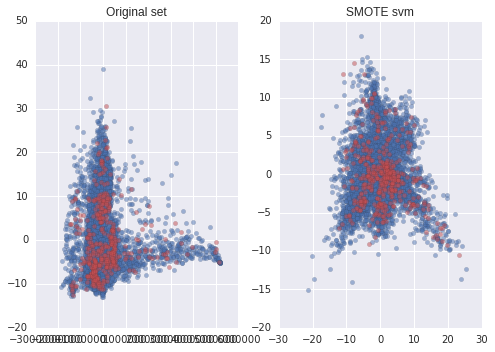

In [163]:
import seaborn as sns

sns.set()


almost_black = '#262626'
palette = sns.color_palette()

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
ax1.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax2.set_title('SMOTE svm')



plt.show()

In [158]:
#scaler = MinMaxScaler()   
        
#Xtrain_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#Xvalid_scaled=pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns, index=X_valid.index )

#Xtest_scaled=pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)
        
y=train['result'].values
y_resampled=y
        
#       PCA transformation 
pcatest=PCA(n_components=4)
X_test=pcatest.fit_transform(train[features])
X_vis=X_test[:,0:2]
X_res_vis=X_test[:,2:4]

print(X_vis.shape,X_res_vis.shape, X_test.shape)

#X_valid_f=pd.DataFrame(pcatest.fit_transform(Xvalid_scaled), index=Xvalid_scaled.index)

#X_test_f=pd.DataFrame(pcatest.fit_transform(Xtest_scaled), index=Xtest_scaled.index)

(5970, 2) (5970, 2) (5970, 4)
